In [13]:
'''
EXPERIMENTS WITH FEATURIZER FOR GRAPH CREATION OF MOLECULES IN LOCALRETRO
'''

base_path = '/home/dominik/AI_Master/Project/my_solution/'
path_to_data = f'{base_path}data/USPTO_50K/'

import pandas as pd
import numpy as np
import dgl
from dgllife.utils import WeaveAtomFeaturizer, CanonicalAtomFeaturizer,\
            CanonicalBondFeaturizer, smiles_to_bigraph, EarlyStopping
from rdkit import Chem
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import SVG
import torch



# HELPER FUNCTIONS AND UTILITY

def canonicalize_smi(smi, is_smarts=False, remove_atom_mapping=True):
    r"""
    Canonicalize SMARTS from https://github.com/rxn4chemistry/rxnfp/blob/master/rxnfp/tokenization.py#L249
    """
    mol = Chem.MolFromSmiles(smi)
    if not mol:
        raise ValueError("Molecule not canonicalizable")
    if remove_atom_mapping:
        for atom in mol.GetAtoms():
            if atom.HasProp("molAtomMapNumber"):
                atom.ClearProp("molAtomMapNumber")
    return Chem.MolToSmiles(mol)

def remove_atom_mapping(smile):
    #this is a very rudiment function which is only proven to work for the one example below!
    result = ''
    for part in smile.rsplit('['):
        end = part.find(']')
        for i in range(end):
            if part[i].isalpha():
                result += part[i]
        result += part[end+1:]
    return result.replace('H', '')

def clear_mapnum(mol):
    [a.ClearProp('molAtomMapNumber') for a in mol.GetAtoms() if a.HasProp('molAtomMapNumber')]
    return mol

def drawMolecule(smiles, bond_idcs=False, atom_idcs=True):
    mol = Chem.MolFromSmiles(smiles)
    d2d = Chem.Draw.rdMolDraw2D.MolDraw2DSVG(350,300)
    d2d.drawOptions().addAtomIndices=atom_idcs
    d2d.drawOptions().addBondIndices=bond_idcs
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return SVG(d2d.GetDrawingText())

class USPTOTestDataset(object):
    def __init__(self, canonicalize_data, use_reduced_testset, load=True, log_every=1000):
        self.canonicalize = canonicalize_data
        if use_reduced_testset:
            df = pd.read_csv(f'{path_to_data}raw_test_reduced.csv')
        else:
            df = pd.read_csv(f'{path_to_data}raw_test.csv')
        self.rxns = df['reactants>reagents>production'].tolist()
        self.smiles = [rxn.split('>>')[-1] for rxn in self.rxns]
        if self.canonicalize and not use_reduced_testset:
            for _ in range(2):
                self.smiles = [canonicalize_smi(smi) for smi in self.smiles]
            self.cache_file_path = f'{base_path}data/saved_graphs/USPTO_50K_test_dglgraph_can.bin'
        elif not self.canonicalize and not use_reduced_testset:
            self.cache_file_path = f'{base_path}data/saved_graphs/USPTO_50K_test_dglgraph.bin'
        elif self.canonicalize and use_reduced_testset:
            for _ in range(2):
                self.smiles = [canonicalize_smi(smi) for smi in self.smiles]
            self.cache_file_path = f'{base_path}data/saved_graphs/USPTO_50K_test_reduced_dglgraph_can.bin'
        elif not self.canonicalize and use_reduced_testset:
            self.cache_file_path = f'{base_path}data/saved_graphs/USPTO_50K_test_reduced_dglgraph.bin' 
        self._pre_process(load, log_every)
        

    def _pre_process(self,load, log_every):
        print('Loading previously saved test dgl graphs...')
        self.graphs, label_dict = dgl.data.utils.load_graphs(self.cache_file_path)

    def __getitem__(self, item):
            return self.smiles[item], self.graphs[item], self.rxns[item]

    def __len__(self):
            return len(self.smiles)


In [14]:
# CREATE DATSET WITH AND WITHOUT CANONICALIZATION
test_set = USPTOTestDataset(canonicalize_data=False, use_reduced_testset=True)
test_set_can = USPTOTestDataset(canonicalize_data=True, use_reduced_testset=True)

Loading previously saved test dgl graphs...
Loading previously saved test dgl graphs...


[CH3:1][C:2]([CH3:3])([CH3:4])[O:5][C:6](=[O:7])[n:15]1[c:14]2[cH:13][cH:12][c:11]([C:9]([CH3:8])=[O:10])[cH:19][c:18]2[cH:17][cH:16]1


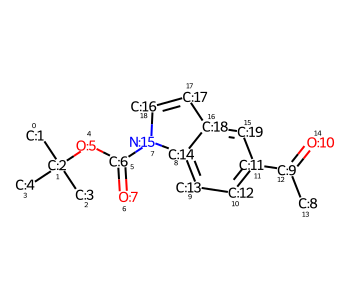

In [15]:
#SHOW EXAMPLE MOLECULE WITHOUT CANONICALIZATION AND WITH ATOM MAPPING
print(test_set[0][0])
drawMolecule(test_set[0][0])

CC(=O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1


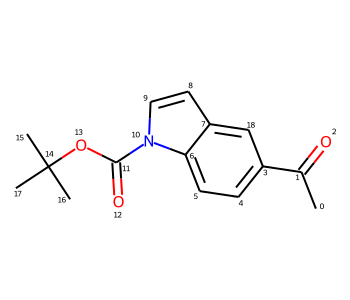

In [16]:
#SHOW EXAMPLE MOLECULE WITH CANONICALIZATION AND WITHOUT ATOM MAPPING
print(test_set_can[0][0])
drawMolecule(test_set_can[0][0])

In [17]:
# PICK EXAMPLE SMILES FROM ABOVE FOR FEATURIZER TESTING
smile = test_set[0][0]

In [18]:
# COMPARE FEATURE REPRESENTATIONS WITH AND WITHOUT CANONICALIZATION

atom_featurizer = WeaveAtomFeaturizer(atom_data_field='feat')
tens_1 = atom_featurizer(Chem.MolFromSmiles(canonicalize_smi(smile)))['feat']
tens_2 = atom_featurizer(Chem.MolFromSmiles(smile))['feat']
mask = torch.eq(tens_1, tens_2)
mask_counter = np.sum([1 for row in mask for i in row if i == False])
print(f'out of {np.prod(mask.shape)} entries {mask_counter} were not equal')
if mask_counter != 0:
    print('the feature reps are not equal. Nums of nonzero entries in reps:')
    print(f'not canonicalized: {torch.count_nonzero(tens_1)}')
    print(f'canonicalized: {torch.count_nonzero(tens_2)}')
else:
    print(f'tensors are equal: {torch.equal(tens_1, tens_2)}')


out of 513 entries 83 were not equal
the feature reps are not equal. Nums of nonzero entries in reps:
not canonicalized: 80
canonicalized: 80


In [19]:
# USE SMILES WITHOUT ATOM MAPPING BUT WITH ORIGINAL ATOM ORDER
smile_wo_mapping = remove_atom_mapping(smile)

atom_featurizer = WeaveAtomFeaturizer(atom_data_field='feat')
tens_1 = atom_featurizer(Chem.MolFromSmiles(smile))['feat']
tens_2 = atom_featurizer(Chem.MolFromSmiles(smile_wo_mapping))['feat']
mask = torch.eq(tens_1, tens_2)
mask_counter = np.sum([1 for row in mask for i in row if i == False])
print(f'out of {np.prod(mask.shape)} entries {mask_counter} were not equal')
if mask_counter != 0:
    print('the feature reps are not equal. Nums of nonzero entries in reps:')
    print(f'not canonicalized: {torch.count_nonzero(tens_1)}')
    print(f'canonicalized: {torch.count_nonzero(tens_2)}')
else:
    print(f'tensors are equal: {torch.equal(tens_1, tens_2)}')

out of 513 entries 0.0 were not equal
tensors are equal: True


In [20]:
# SINCE THEY ARE EQUAL, LET'S COMPARE THIS REPRESENTATION WITH AND WITHOUT CANONICALIZATION
atom_featurizer = WeaveAtomFeaturizer(atom_data_field='feat')
tens_1 = atom_featurizer(Chem.MolFromSmiles(smile_wo_mapping))['feat']
tens_2 = atom_featurizer(Chem.MolFromSmiles(canonicalize_smi(smile_wo_mapping)))['feat']
mask = torch.eq(tens_1, tens_2)
mask_counter = np.sum([1 for row in mask for i in row if i == False])
print(f'out of {np.prod(mask.shape)} entries {mask_counter} were not equal')
if mask_counter != 0:
    print('the feature reps are not equal. Nums of nonzero entries in reps:')
    print(f'not canonicalized: {torch.count_nonzero(tens_1)}')
    print(f'canonicalized: {torch.count_nonzero(tens_2)}')
else:
    print(f'tensors are equal: {torch.equal(tens_1, tens_2)}')

out of 513 entries 83 were not equal
the feature reps are not equal. Nums of nonzero entries in reps:
not canonicalized: 80
canonicalized: 80


In [21]:
#SINCE THEY ARE NOT EQUAL, LET'S INSPECT THE DIFFERENCES IN THE ENTRIES
# we can see, that the sum of differences is 0, the entries are equal, but differently ordered!
diff = 0
for i, row in enumerate(mask):
    for j, val in enumerate(row):
        if not val:
            print(tens_1[i, j].item(), tens_2[i, j].item())
            diff += tens_1[i, j].item() - tens_2[i, j].item()
print(f'the sum of differences is: {diff}')

-0.025260789319872856 -0.0009061949676834047
0.10570123046636581 0.15932278335094452
0.0 1.0
1.0 0.0
1.0 0.0
0.0 1.0
-0.025260789319872856 -0.2945117950439453
0.0 1.0
1.0 0.0
0.0 1.0
-0.025260789319872856 0.017938340082764626
0.0 1.0
0.0 1.0
1.0 0.0
0.0 1.0
0.0 1.0
1.0 0.0
-0.44319069385528564 -0.04929739609360695
0.0 1.0
1.0 0.0
0.0 1.0
0.418490469455719 -0.03648368641734123
0.0 1.0
0.0 1.0
0.0 1.0
1.0 0.0
-0.22351661324501038 0.05902611091732979
0.0 1.0
1.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0
1.0 0.0
-0.2525884807109833 0.0008986711618490517
0.0 1.0
0.05902611091732979 -0.03588978573679924
1.0 0.0
-0.03648368641734123 0.016320085152983665
0.0 1.0
1.0 0.0
1.0 0.0
0.0 1.0
-0.04929739609360695 -0.2525884807109833
0.0 1.0
1.0 0.0
0.017938340082764626 0.418490469455719
1.0 0.0
1.0 0.0
1.0 0.0
0.0 1.0
0.15932278335094452 -0.22351661324501038
0.0 1.0
1.0 0.0
0.0 1.0
-0.0009061949676834047 -0.44319069385528564
0.0 1.0
1.0 0.0
0.0 1.0
0.0 1.0
1.0 0.0
-0.2945117950439453 0.10570123046636581
1.0 0.0
0.